# 0. Imports

In [10]:
import itertools
import os
import pandas as pd
pd.set_option("display.max_rows", 100)
import re
import matplotlib.pyplot as plt

import langchain
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
import chromadb

from evaluate import load
import transformers
import torch
print(torch.cuda.is_available())

main_path = os.path.dirname(os.getcwd())

True


## 0.1. Batch

In [11]:
Batch_GridSearch = {
    "Chunk-size": [3000,7000],
    "Top-k": [3,4,5,6,7,8,9],
    "Embeddings model" : ["Alibaba-NLP/gte-large-en-v1.5"],
    "Top-N":[50,70] 
}

# To initialize the vector store already created
model_kwargs = {'device': 'cuda',"trust_remote_code":True}
embeddings = HuggingFaceEmbeddings(
    model_name=Batch_GridSearch["Embeddings model"][0],
    model_kwargs=model_kwargs,
)

## 0.2. Functions

### 0.2.1 Other

In [12]:
def limpar_texto(texto):
    # Transformar em minúsculas
    texto = texto.lower()
    # Remover caracteres específicos
    texto = texto.replace("(", "").replace(")", "").replace(",", "").replace("\n", " ").replace("\xa0"," ")
    texto = re.sub(r"\. ", " ", texto)
    texto = re.sub(r"\! ", " ", texto)
    texto = re.sub(r"\" ", " ", texto)
    texto = re.sub(r'"(\w+)', r'\1', texto)  # Remove apenas a aspas antes da palavra
    texto = re.sub(r"\: ", " ", texto)
    texto = texto.replace("  ", " ")
    texto = texto.replace(" - ", " ")
    texto = re.sub(r"'s\b", "", texto)  # Remove apenas 's no final de palavras
    
    return texto

def BM25TextPreparation(data,Series_metadata, chunk_size):
    text_splitter =  RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,  # Max number of characters per chunk
    # chunk_overlap=chunk_overlap  # Overlap between chunks for better context retention
    )

    # Step 2: Prepare an empty list to store documents with their associated metadata
    split_docs = []

    # Step 3: Loop through each record in `data["Final"]` and split it, keeping the source ("Fonte")
    for i, final_text in enumerate(data):
        # Split the text into chunks
        docs = text_splitter.create_documents([final_text])
        
        # Add the "Fonte" to the metadata of each document
        for doc in docs:
        
            doc.metadata = {"Source":Series_metadata[i]}  # Associate each chunk with the correct source
            split_docs.append(doc)  # Store the document with the metadata

    return split_docs


def contar_caracteres(celula):
    if isinstance(celula, list):  # Verifica se a célula é uma lista
        return min([len(texto) for texto in celula])  # Soma o comprimento de cada string na lista
    elif isinstance(celula, str):  # Verifica se a célula é uma string
        return len(celula)
    else:
        return 0  # Caso a célula esteja vazia ou seja de outro tipo

### 0.2.2 Dense Vector Retriever

In [13]:
def BaseRetriever(testset,vectorstore,k):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    Hit_Rate_general = []
    Retrieved_Docs = []
    for question, context in zip(testset["Question"],testset["Context"]):
         
        Hit_Rate_perquestion = []
        base_retriever = retriever.invoke(question)
        Retrieved_Docs.append([d.page_content for d in base_retriever])
        
        ### HIT RATE
        for doc in base_retriever:
            for cont in context:
                if cont in doc.page_content:
                    Hit_Rate_perquestion.append(1)
                else:
                    Hit_Rate_perquestion.append(0)
        if 1 in Hit_Rate_perquestion:
            # print(question,1)
            Hit_Rate_general.append(1)
        else:
            # print(question,0)
            Hit_Rate_general.append(0)
                
    TestSet_results = testset

    TestSet_results["Retrieved Docs"] = Retrieved_Docs
    TestSet_results["Hit Rate"] = Hit_Rate_general
    return TestSet_results




### 0.2.3 Hybrid Search Retriever

In [14]:
def Ensemble_Retriever(testset,vectorstore,bm25_text, k):
    bm25_retriever = BM25Retriever.from_documents(bm25_text)
    bm25_retriever.k = k
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})

    ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5])
    
    Contextos = []
    lista_contextos = []
    for contextos in testset["Context"].to_list():
        for contexto in contextos:
            lista_contextos.append(limpar_texto(contexto))

        Contextos.append(lista_contextos)
        lista_contextos = []

    testset["Context_treated"] = Contextos

    Hit_Rate_general = []
    Retrieved_Docs = [] 
    for question, context in zip(testset["Question"],testset["Context_treated"]):
        Hit_Rate_perquestion = []
        compressed_docs = ensemble_retriever.invoke(question.lower())

        Retrieved_Docs.append([d.page_content for d in compressed_docs])
        ## HIT RATE
        for doc in compressed_docs:
            for cont in context:
                if cont in doc.page_content:
                    Hit_Rate_perquestion.append(1)
                else:
                    Hit_Rate_perquestion.append(0)
        if 1 in Hit_Rate_perquestion:
            # print(question,1)
            Hit_Rate_general.append(1)
        else:
            # print(question,0)
            Hit_Rate_general.append(0)
        
    TestSet_results = testset

    TestSet_results["Retrieved Docs"] = Retrieved_Docs
    TestSet_results["Hit Rate"] = Hit_Rate_general
    return TestSet_results

### 0.2.4 Hybrid Search Retriever +  Reranking

In [15]:
def Ensemble_Retriever_rerank(testset,vectorestore,bm25_text,initial_k,k):
    bm25_retriever = BM25Retriever.from_documents(bm25_text)
    bm25_retriever.k = initial_k
    retriever = vectorestore.as_retriever(search_kwargs={"k": initial_k})

    ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5])
    model = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2", model_kwargs = {'device': 'cuda'})
    # model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-large-en-v1.5", model_kwargs = {'device': 'cuda'})
    compressor = CrossEncoderReranker(model=model, top_n=k)
    compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=ensemble_retriever)


    Contextos = []
    lista_contextos = []
    for contextos in testset["Context"].to_list():
        for contexto in contextos:
            lista_contextos.append(limpar_texto(contexto))

        Contextos.append(lista_contextos)
        lista_contextos = []

    testset["Context_treated"] = Contextos

    Hit_Rate_general = []

    Retrieved_Docs = [] 
    for question, context in zip(testset["Question"],testset["Context_treated"]):
        Hit_Rate_perquestion = []
        MRR_perquestion = []
        compressed_docs = compression_retriever.invoke(question.lower())

        Retrieved_Docs.append([d.page_content for d in compressed_docs])

        ## HIT RATE
        for doc in compressed_docs:
            for cont in context:
                if cont in doc.page_content:
                    Hit_Rate_perquestion.append(1)
                else:
                    Hit_Rate_perquestion.append(0)
        if 1 in Hit_Rate_perquestion:
            Hit_Rate_general.append(1)
        else:
            Hit_Rate_general.append(0)
        

    TestSet_results = testset

    TestSet_results["Retrieved Docs"] = Retrieved_Docs
    TestSet_results["Hit Rate"] = Hit_Rate_general

    return TestSet_results

# 1. Data

## 1.1 Dataset

In [16]:
# need to import the Corpus again to create the sparse vector for BM25Retriever
df_db = pd.read_excel(main_path+"\\2_Data\\1_Final\\Dataset_Final.xlsx").drop("Unnamed: 0", axis=1)

# Clean text in order to have exactly the same text that is stored in the vector databases. Otherwise the Reciprocal Ranking Fusion formula will not work.
df_db["Texto_lower"] = [limpar_texto(texto) for texto in df_db["Texto"].to_list()]

# list with the documents in the corpus with the different chunk-sizes
texts_3000 = BM25TextPreparation(df_db["Texto_lower"].to_list(),df_db["Source"],3000)
texts_7000 = BM25TextPreparation(df_db["Texto_lower"].to_list(),df_db["Source"],7000)

# Dict to later pick the documents
texts_BM25 = {"3000":texts_3000,
              "7000":texts_7000}


## 1.2 Test Set

In [17]:
TestSet = pd.read_excel(main_path+"\\2_Data\\3_TestSet\\FAQ.xlsx",sheet_name="Question-Context-Answer")
TestSet = TestSet[TestSet['Context']!="-"]
TestSet['Context'] = TestSet['Context'].str.replace(r'\\n', '\n', regex=True)
TestSet_grouped = TestSet.groupby('Question')['Context'].agg(list).reset_index()
TestSet_grouped["Nº of Possible Contexts"] = TestSet_grouped["Context"].apply(lambda x: len(x))

# Column to check if the Contexts have at least one context per question in which the number of characters is <3000, otherwise when chunking the data by 3000 characters
# it would be impossible for the model to acertar no documento.
TestSet_grouped['MinNumberCharactersContext'] = TestSet_grouped['Context'].apply(contar_caracteres)
TestSet_grouped.head()

,Question,Context,Nº of Possible Contexts,MinNumberCharactersContext
0,Are there any festivals or events happening in...,[Every year Porto have events and festivals. T...,4,1321
1,Are there any guided tours available in Porto?,[The best Porto guided Tours that you can expe...,1,281
2,Best wineries to visit in Vila Nova de Gaia,[Ferreira Cellars is one of the most extraordi...,2,48
3,Can you recommend any traditional Portuguese r...,[Some of the most traditional Portuguese Resta...,2,255
4,Can you recommend any wine tours in Porto?,[Vinic Tours is a located in Rua das Moutas N0...,3,262


# 2. GridSearch

In [18]:
BaseRetriever_Hit_Rate_perc = {"Retriever":[],
                               "chunk_size":[],
                                "Retriever_N":[],
                                "CrossEncoder_N":[],
                                "Mean_Hit_Rate":[]}

EnsembleRetriever_Hit_Rate_perc = {"Retriever":[],
                               "chunk_size":[],
                                "Retriever_N":[],
                                "CrossEncoder_N":[],
                                "Mean_Hit_Rate":[]}


EnsembleRetrieverRerank_Hit_Rate_perc = {"Retriever":[],
                               "chunk_size":[],
                                "Retriever_N":[],
                                "CrossEncoder_N":[],
                                "Mean_Hit_Rate":[]}



for chunk_size in Batch_GridSearch["Chunk-size"]:
    print(chunk_size)
    vector_db_name = "DB_Porto_Final_alibaba_embeddings_"+str(chunk_size)
    vector_store = Chroma(collection_name=vector_db_name,
    persist_directory=main_path+"\\2_Data\\2_DBs\\", embedding_function=embeddings)

    vector_db_name_ensemble = "DB_Porto_Final_alibaba_embeddings_treated_"+str(chunk_size)
    vector_store_ensemble = Chroma(collection_name=vector_db_name_ensemble,
    persist_directory=main_path+"\\2_Data\\2_DBs\\", embedding_function=embeddings)
    
    for k in Batch_GridSearch["Top-k"]:
        df_base_retriever = BaseRetriever(TestSet_grouped,vector_store,k=k)
        BaseRetriever_Hit_Rate_perc["Retriever"].append("BaseRetriever")
        BaseRetriever_Hit_Rate_perc["chunk_size"].append(chunk_size)
        BaseRetriever_Hit_Rate_perc["Retriever_N"].append(k)
        BaseRetriever_Hit_Rate_perc["CrossEncoder_N"].append("")
        BaseRetriever_Hit_Rate_perc["Mean_Hit_Rate"].append((df_base_retriever["Hit Rate"].sum()/df_base_retriever["Hit Rate"].shape[0])*100)

        df_ensemble_retriever = Ensemble_Retriever(TestSet_grouped,vector_store_ensemble,texts_BM25[str(chunk_size)],k=k)
        EnsembleRetriever_Hit_Rate_perc["Retriever"].append("EnsembleRetriever")
        EnsembleRetriever_Hit_Rate_perc["chunk_size"].append(chunk_size)
        EnsembleRetriever_Hit_Rate_perc["Retriever_N"].append(k)
        EnsembleRetriever_Hit_Rate_perc["CrossEncoder_N"].append("")
        EnsembleRetriever_Hit_Rate_perc["Mean_Hit_Rate"].append((df_ensemble_retriever["Hit Rate"].sum()/df_ensemble_retriever["Hit Rate"].shape[0])*100)

        for rerank_n in Batch_GridSearch["Top-N"]: 
            df_ensemble_retriever_rerank = Ensemble_Retriever_rerank(TestSet_grouped,vectorestore=vector_store_ensemble,bm25_text=texts_BM25[str(chunk_size)],initial_k=rerank_n,k=k)
            EnsembleRetrieverRerank_Hit_Rate_perc["Retriever"].append("EnsembleRetrieverRerank")
            EnsembleRetrieverRerank_Hit_Rate_perc["chunk_size"].append(chunk_size)
            EnsembleRetrieverRerank_Hit_Rate_perc["Retriever_N"].append(k)
            EnsembleRetrieverRerank_Hit_Rate_perc["CrossEncoder_N"].append(rerank_n)
            EnsembleRetrieverRerank_Hit_Rate_perc["Mean_Hit_Rate"].append((df_ensemble_retriever_rerank["Hit Rate"].sum()/df_ensemble_retriever_rerank["Hit Rate"].shape[0])*100)
        


df_final_base_retriever = pd.DataFrame(BaseRetriever_Hit_Rate_perc)
df_final_ensemble_retriever = pd.DataFrame(EnsembleRetriever_Hit_Rate_perc)
df_final_ensemble_retriever_rerank = pd.DataFrame(EnsembleRetrieverRerank_Hit_Rate_perc)

df_final_all_retrievers = pd.concat(
    [df_final_base_retriever, df_final_ensemble_retriever,df_final_ensemble_retriever_rerank],
    ignore_index=True
)

df_final_all_retrievers.to_excel(main_path+"\\3_Results\\1_Tabelas\\1_Resultados_Retriever.xlsx")

df_final_all_retrievers

3000
7000


,Retriever,chunk_size,Retriever_N,CrossEncoder_N,Mean_Hit_Rate
0,BaseRetriever,3000,3,,67.1875
1,BaseRetriever,3000,4,,70.3125
2,BaseRetriever,3000,5,,70.3125
3,BaseRetriever,3000,6,,70.3125
4,BaseRetriever,3000,7,,70.3125
5,BaseRetriever,3000,8,,70.3125
6,BaseRetriever,3000,9,,70.3125
7,BaseRetriever,7000,3,,67.1875
8,BaseRetriever,7000,4,,71.8750
9,BaseRetriever,7000,5,,73.4375


In [19]:
df_final_all_retrievers.to_excel(main_path+"\\3_Results\\1_Tabelas\\1_Resultados_Retriever.xlsx")

# 2. Plot

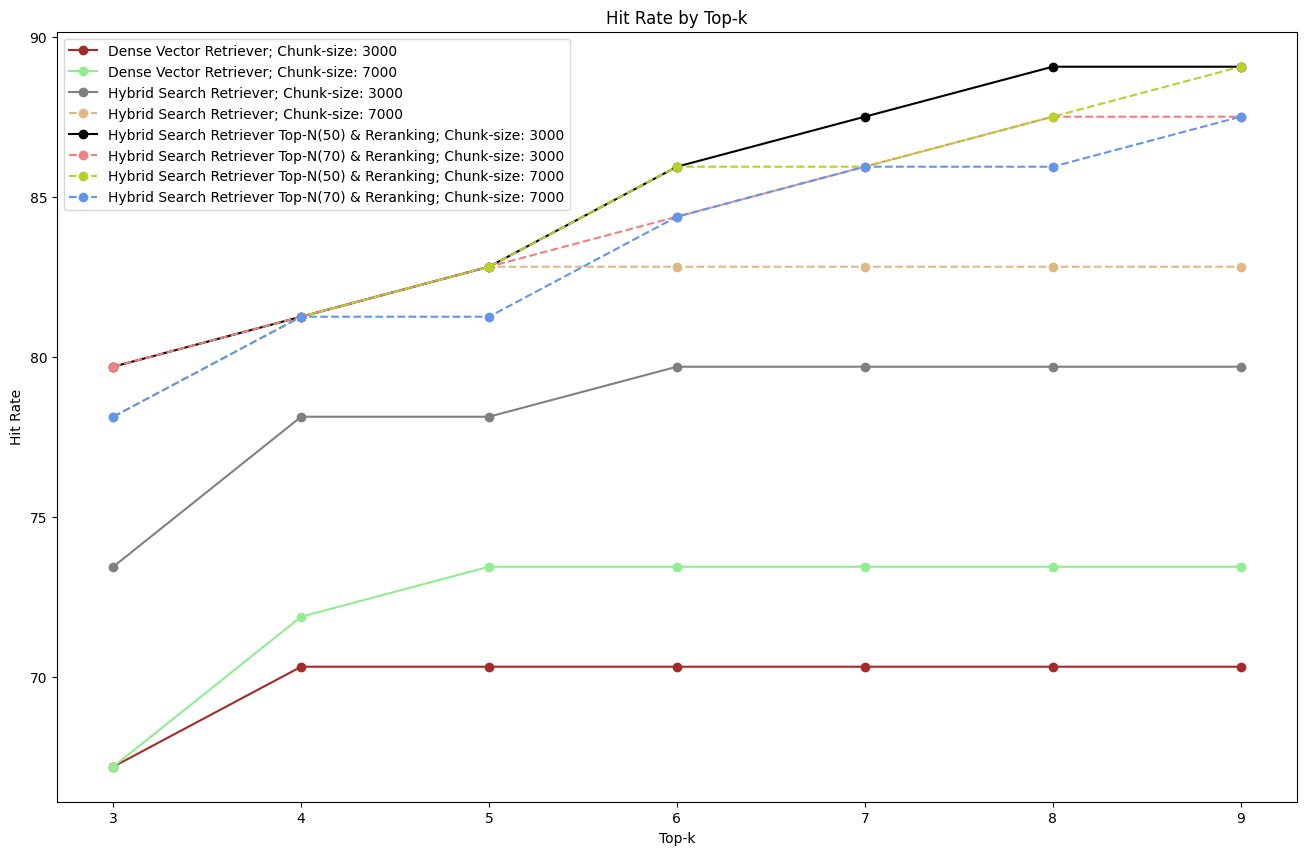

In [22]:
df_final_all_retrievers2 = df_final_all_retrievers
df_final_all_retrievers2["RetrieverFinal"] = df_final_all_retrievers2["Retriever"]+df_final_all_retrievers2["CrossEncoder_N"].astype(str)
df_final_all_retrievers2['RetrieverFinal'] = df_final_all_retrievers2['RetrieverFinal'].replace('BaseRetriever', 'Dense Vector Retriever')
df_final_all_retrievers2['RetrieverFinal'] = df_final_all_retrievers2['RetrieverFinal'].replace('EnsembleRetriever', 'Hybrid Search Retriever')
df_final_all_retrievers2['RetrieverFinal'] = df_final_all_retrievers2['RetrieverFinal'].replace('EnsembleRetrieverRerank50', 'Hybrid Search Retriever Top-N(50) & Reranking')
df_final_all_retrievers2['RetrieverFinal'] = df_final_all_retrievers2['RetrieverFinal'].replace('EnsembleRetrieverRerank70', 'Hybrid Search Retriever Top-N(70) & Reranking')


df_final_all_retrievers_BASE_3000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Dense Vector Retriever") & (df_final_all_retrievers2["chunk_size"]==3000)]
df_final_all_retrievers_BASE_7000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Dense Vector Retriever") & (df_final_all_retrievers2["chunk_size"]==7000)]

df_final_all_retrievers_Ensemble_3000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever") & (df_final_all_retrievers2["chunk_size"]==3000)]
df_final_all_retrievers_Ensemble_7000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever") & (df_final_all_retrievers2["chunk_size"]==7000)]

df_final_all_retrievers_EnsembleRerank50_3000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever Top-N(50) & Reranking") & (df_final_all_retrievers2["chunk_size"]==3000)]
df_final_all_retrievers_EnsembleRerank70_3000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever Top-N(70) & Reranking") & (df_final_all_retrievers2["chunk_size"]==3000)]
df_final_all_retrievers_EnsembleRerank50_7000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever Top-N(50) & Reranking") & (df_final_all_retrievers2["chunk_size"]==7000)]
df_final_all_retrievers_EnsembleRerank70_7000 = df_final_all_retrievers2[(df_final_all_retrievers2["RetrieverFinal"]=="Hybrid Search Retriever Top-N(70) & Reranking") & (df_final_all_retrievers2["chunk_size"]==7000)]


# Criando o gráfico
plt.figure(figsize=(16, 10))

# Linha para o primeiro DataFrame
plt.plot(df_final_all_retrievers_BASE_3000['Retriever_N'], df_final_all_retrievers_BASE_3000['Mean_Hit_Rate'], label='Dense Vector Retriever; Chunk-size: 3000', marker='o', color='brown')
plt.plot(df_final_all_retrievers_BASE_7000['Retriever_N'], df_final_all_retrievers_BASE_7000['Mean_Hit_Rate'], label='Dense Vector Retriever; Chunk-size: 7000', marker='o',color="lightgreen")

plt.plot(df_final_all_retrievers_Ensemble_3000['Retriever_N'], df_final_all_retrievers_Ensemble_3000['Mean_Hit_Rate'], label='Hybrid Search Retriever; Chunk-size: 3000', marker='o', color="gray")
plt.plot(df_final_all_retrievers_Ensemble_7000['Retriever_N'], df_final_all_retrievers_Ensemble_7000['Mean_Hit_Rate'], label='Hybrid Search Retriever; Chunk-size: 7000', marker='o',color="burlywood", linestyle='--')

plt.plot(df_final_all_retrievers_EnsembleRerank50_3000['Retriever_N'], df_final_all_retrievers_EnsembleRerank50_3000['Mean_Hit_Rate'], label='Hybrid Search Retriever Top-N(50) & Reranking; Chunk-size: 3000', marker='o', color="black")
plt.plot(df_final_all_retrievers_EnsembleRerank70_3000['Retriever_N'], df_final_all_retrievers_EnsembleRerank70_3000['Mean_Hit_Rate'], label='Hybrid Search Retriever Top-N(70) & Reranking; Chunk-size: 3000', marker='o',color="lightcoral", linestyle='--')

plt.plot(df_final_all_retrievers_EnsembleRerank50_7000['Retriever_N'], df_final_all_retrievers_EnsembleRerank50_7000['Mean_Hit_Rate'], label='Hybrid Search Retriever Top-N(50) & Reranking; Chunk-size: 7000', marker='o', color='#bad02a', linestyle='--')
plt.plot(df_final_all_retrievers_EnsembleRerank70_7000['Retriever_N'], df_final_all_retrievers_EnsembleRerank70_7000['Mean_Hit_Rate'], label='Hybrid Search Retriever Top-N(70) & Reranking; Chunk-size: 7000', marker='o',color="cornflowerblue", linestyle='--')


# Configurações do gráfico
plt.xlabel('Top-k')



plt.ylabel('Hit Rate')
plt.title('Hit Rate by Top-k')
plt.legend(fontsize=10)
# plt.grid(True)

# Exibir o gráfico
plt.show()